In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
from torch.utils.data.dataset import Dataset
import time
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
%matplotlib inline
import torch.nn.functional as F
import pandas as pd

In [4]:
## read target file 

y_target = pd.read_csv('C:\\Users\\DEBORNE\\Desktop\\HEC\\\X  seminar - Deep learning\\y_target.csv')
y_target['code'] = y_target['code'].astype(str)
y_target.set_index(['code'],inplace=True)
y_target.head(2)

,Barquette,Bocal,Boite,Bouteille,Brique,Carton,Conserve,Metal,Papier,Plastique,Pot,Sachet,Verre
code,,,,,,,,,,,,,
0000000001281,1,0,0,0,0,0,0,0,0,1,0,0,0
0000000020114,0,1,0,0,0,0,0,0,0,1,0,0,0


In [5]:
# get list of all the image name in folder - X_sample.rar already dezip in one folder 

list_files = os.listdir('C:\\Users\\DEBORNE\\Desktop\\HEC\\\X  seminar - Deep learning\\data\\')
#removing .jpeg extension
list_files =  [x[:-4] for x in list_files]

# create Y_target with only rows in the folder
Y = y_target[y_target.index.isin(list_files)]

#remove the images that have not been match in the folder for more clarity 
to_remove = [x for x in list_files if x not in list(Y.index)]
for i in to_remove:
     os.remove('C:\\Users\\DEBORNE\\Desktop\\HEC\\\X  seminar - Deep learning\\data\\'+str(i)+'.jpg')

In [7]:
# Custom pytorch dataset that return tuple of tensor img , tensor Y
class MultiLabelDataset(Dataset):
    """MultiLabelDataset."""

    def __init__(self, df, root_dir_img, transform=None):
        """
        Args:
            df(pandas dataframe): target dataframe with class one hot encoded and index name of the images.
            root_dir_img (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = df
        self.root_dir_img = root_dir_img
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir_img,
                                str(self.df.index[idx])+'.jpg')
        img = Image.open(img_name)
        img = img.convert('RGB')
        
        if self.transform is not None:
            
            img = self.transform(img)
        label = torch.Tensor(Y.iloc[idx].tolist())

        return img,label

In [8]:
# transformation of image pipe - at random - don't fortget to transform to tensor 
transformations = transforms.Compose([transforms.Scale(256),transforms.CenterCrop(224),transforms.ToTensor()])

# pytorch dataset
train = MultiLabelDataset(df=Y,
                  root_dir_img='C:\\Users\\DEBORNE\\Desktop\\HEC\\X  seminar - Deep learning\\data\\',
                  transform=transformations)

# pytorch loader - same as dataset but in batch and shuffle 
train_loader = DataLoader(train,
                          batch_size=16,
                          shuffle=True,
                          num_workers=0
                         )

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


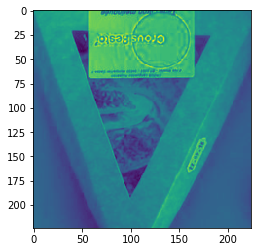

In [9]:
# plot of an image 
plt.figure()
plt.imshow(train[0][0][0].numpy())
plt.show()


In [11]:
## Multi label NN - architecture at random 
class MultiLabelNN(nn.Module):
    def __init__(self, nlabel):
        super(MultiLabelNN, self).__init__()
        self.nlabel = nlabel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2876416,24)
        #self.fc1 = nn.Linear(224*224*3,24)
        self.fc2 = nn.Linear(24, nlabel)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        # x = self.pool(x)
        #x = x.view(-1, 3*224*224)
        x = x.view(-1, 2876416)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


In [12]:
## run the model on train only - only work with GPU... see error below
use_gpu = torch.cuda.is_available()
model = MultiLabelNN(13)
if use_gpu:
    model = model.cuda()


optimizer = optim.SGD(model.parameters(), lr=0.0001)
criterion = nn.MultiLabelMarginLoss()

epochs = 3
for epoch in range(epochs):
    ### training phase
    total_training_loss = 0.0
    for iter, traindata in enumerate(train_loader, 0):
        train_inputs, train_labels = traindata
        if use_gpu:
            train_inputs, train_labels = Variable(train_inputs.cuda()), Variable(train_labels.cuda())
        else: train_inputs, train_labels = Variable(train_inputs), Variable(train_labels)

        optimizer.zero_grad()

        train_outputs = model(train_inputs)
        loss = criterion(train_outputs.long(), train_labels.long())
        loss.backward()
        optimizer.step()

        # total += train_labels.size(0)
        total_training_loss += loss.data[0]
        print('Training Phase: Epoch: [%2d][%2d/%2d]\tIteration Loss: %.3f' %
              (iter, epoch, epochs, loss.data[0] / train_labels.size(0)))


RuntimeError: _thnn_multilabel_margin_loss_forward not supported on CPUType for Long